In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
import time
import copy
import gc
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
device

device(type='cuda')

In [4]:
writer = SummaryWriter(log_dir="runs")

In [5]:
BATCH_SIZE = 64
NUM_WORKERS = 2

In [6]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

In [7]:
# transforms labels to one-hot vectors
def label_transform(image):
    ls = []
    for d in image['annotation']['object']:
        ls.append(class_names.index(d['name']))

    indices = np.zeros(shape=(len(class_names)))
    for d in image['annotation']['object']:
        indices[class_names.index(d['name'])] = 1

    return torch.from_numpy(indices)

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'trainval': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
image_datasets = {x: torchvision.datasets.voc.VOCDetection(root=f"data/{x}", year="2007", image_set=x, download=True, transform=data_transforms[x], target_transform=label_transform)
                  for x in ['train', 'trainval', 'test']}

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting data/train/VOCtrainval_06-Nov-2007.tar to data/train


  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting data/trainval/VOCtrainval_06-Nov-2007.tar to data/trainval


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting data/test/VOCtest_06-Nov-2007.tar to data/test


In [10]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
               for x in ['train', 'trainval', 'test']}

In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'trainval', 'test']}

In [12]:
dataset_sizes

{'train': 2501, 'trainval': 5011, 'test': 4952}

In [13]:
count_dict = {class_name: 0 for class_name in class_names}
for i in range(len(image_datasets['train'])):
    for target in np.array(class_names)[np.where(image_datasets['train'][i][1])]:
        count_dict[target] +=1

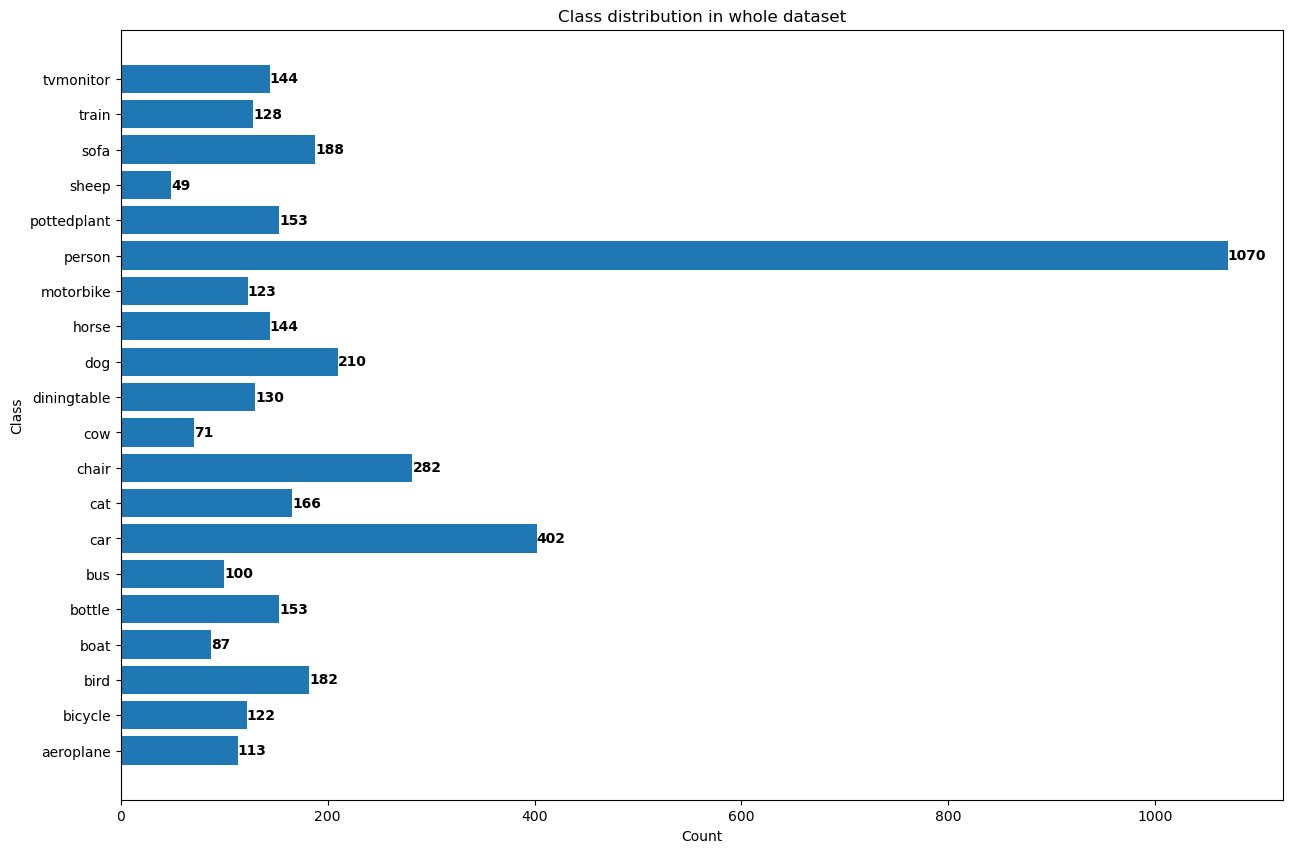

In [14]:
plt.figure(figsize=(15,10))
plt.barh(y=list(count_dict.keys()), width=list(count_dict.values()))
plt.title('Class distribution in whole dataset')
plt.xlabel('Count')
plt.ylabel('Class')
for i, v in enumerate(list(count_dict.values())):
    plt.text(v, i, str(v), color='black', va='center', fontweight='bold')

In [16]:
resnet = torch.load("/kaggle/input/early-late-models/early_late_models/resnet50.pth")
inception = torch.load("/kaggle/input/early-late-models/early_late_models/inceptionv3.pth")

In [17]:
resnet_conv = nn.Sequential(*list(resnet.children())[:-2])
inception_conv = nn.Sequential(*list(inception.children())[:-2])

In [18]:
resnet_conv.eval()
inception_conv.eval()

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, moment

In [19]:
def extract_features(model, dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            target = target.to(device)
            features.append(model(inputs).squeeze())
            labels.append(target)
    features = torch.cat(features)
    labels = torch.cat(labels)
    return features, labels

In [20]:
train_features_resnet, train_labels_resnet = extract_features(resnet_conv, dataloaders['train'])
val_features_resnet, val_labels_resnet = extract_features(resnet_conv, dataloaders['trainval'])
test_features_resnet, test_labels_resnet = extract_features(resnet_conv, dataloaders['test'])

In [21]:
train_features_inception, train_labels_inception = extract_features(inception_conv, dataloaders['train'])
val_features_inception, val_labels_inception = extract_features(inception_conv, dataloaders['trainval'])
test_features_inception, test_labels_inception = extract_features(inception_conv, dataloaders['test'])

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 1000]

In [ ]:
train_features = torch.cat((train_features_resnet, train_features_inception), dim=1)
val_features = torch.cat((val_features_resnet, val_features_inception), dim=1)
test_features = torch.cat((test_features_resnet, test_features_inception), dim=1)

In [22]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(train_features_resnet.cpu().numpy(), train_labels_resnet.cpu().numpy())
val_predictions = svm.predict(val_features.cpu().numpy())
test_predictions = svm.predict(test_features.cpu().numpy())

print("Validation F1 Score (micro): ", f1_score(val_labels_resnet.cpu().numpy(), val_predictions, average='micro'))
print("Test F1 Score (micro): ", f1_score(test_labels_resnet.cpu().numpy(), test_predictions, average='micro'))


ValueError: Found array with dim 4. Estimator expected <= 2.

In [ ]:
fc_classifier = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 20)
)
fc_classifier = fc_classifier.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(fc_classifier.parameters(), lr=0.001, momentum=0.9)

train_features = get_concatenated_features(train_inputs).cpu().numpy()
train_labels = train_targets.cpu().numpy()
svm_classifier.fit(train_features, train_labels)

num_epochs = 10
for epoch in range(num_epochs):
    for inputs, targets in dataloaders['train']:
        inputs = inputs.to(device)
        targets = targets.to(device)

        features = get_concatenated_features(inputs)
        outputs = fc_classifier(features)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
class LateFusion(nn.Module):
    def __init__(self, resnet, inception):
        super(LateFusion, self).__init__()
        self.resnet = resnet
        self.inception = inception
        self.fc = nn.Linear(resnet.fc.out_features + inception.fc.out_features, len(class_names))

    def forward(self, x):
        resnet_out = self.resnet(x)
        inception_out = self.inception(x)
        late_fusion_out = torch.cat((resnet_out, inception_out), dim=1)
        # apply the late fusion operator
        return self.fc(late_fusion_out)

model = LateFusion(resnet, inception)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model.train()
        else:
            model.eval()

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                preds = (outputs > 0.5).float()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if phase == 'val':
            scheduler.step(epoch_loss)

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print('F1-score: {:.4f}'.format(f1_score(y_true, y_pred, average)

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    outputs = []
    targets = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs.append(model(inputs).cpu())
            targets.append(labels.cpu())
            outputs = torch.cat(outputs, dim=0)
            targets = torch.cat(targets, dim=0)
    return outputs, targets

In [ ]:
resnet_outputs, resnet_targets = evaluate_model(resnet, dataloaders['test'])
inception_outputs, inception_targets = evaluate_model(inception, dataloaders['test'])

In [ ]:
def compute_f1_score(outputs, targets):
    _, preds = torch.max(outputs, dim=1)
    f1 = f1_score(targets, preds, average='weighted')
    return f1

In [ ]:
resnet_f1_score = compute_f1_score(resnet_outputs, resnet_targets)
inception_f1_score = compute_f1_score(inception_outputs, inception_targets)

print(f"Resnet50 F1 score: {resnet_f1_score:.4f}")
print(f"Inceptionv3 F1 score: {inception_f1_score:.4f}")